In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy

import torch
from torch_geometric import EdgeIndex
from torch_geometric.utils import degree
from torch_geometric.loader import LinkNeighborLoader, NeighborLoader
from torch_geometric.nn import MIPSKNNIndex
from torch_geometric.metrics import LinkPredMAP, LinkPredPrecision, LinkPredRecall
from torch_geometric.nn.models.lightgcn import BPRLoss

from tqdm import tqdm
import os
os.environ['PYDEVD_DISABLE_FILE_VALIDATION']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from utils.model import GNN

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
faiss_device = torch.device('cpu')

In [2]:
from utils.data_transformation import data_to_heterograph

data, users_rev_mapping, movies_rev_mapping =\
    data_to_heterograph('./data/processed/encoded_data.npz')

edges = data['user', 'movie'].edge_index
time = data['user', 'movie'].time

num_users, num_movies = data['user'].num_nodes, data['movie'].num_nodes
user_dim, movie_dim = data['user'].num_features, data['movie'].num_features

data

HeteroData(
  movie={
    x=[11909, 300],
    num_features=300,
  },
  user={
    x=[448798, 14],
    num_features=14,
  },
  (user, watched, movie)={
    edge_index=[2, 1288996],
    time=[1288996],
  },
  (movie, rev_watched, user)={
    edge_index=[2, 1288996],
    time=[1288996],
  }
)

## Train/test split

In [8]:
train_ratio = 0.8
train_size = int(train_ratio * data['user', 'movie'].num_edges)-1
train_watch_threshold = -1

loss_type = 'trl'
neg_sampling_ratio = 50
batch_size = 256

neg_sampling_mode = 'binary' if loss_type == 'bce' else 'triplet'
loader_kwargs = dict(
    data=data, batch_size=batch_size,
    num_neighbors=[15],
    time_attr='time', temporal_strategy='last',
    num_workers=4)

train_loader = LinkNeighborLoader(
    edge_label_index=(('user', 'movie'), edges[:, :train_size]),
    edge_label_time=time[torch.arange(train_size)]-1,
    neg_sampling=dict(mode=neg_sampling_mode, amount=neg_sampling_ratio),
    shuffle=True,
    **loader_kwargs)

user_loader = NeighborLoader(
    input_nodes='user',
    input_time=(time[train_size]-1).repeat(num_users),
    **loader_kwargs)

movie_loader = NeighborLoader(
    input_nodes='movie',
    input_time=(time[train_size]-1).repeat(num_movies),
    **loader_kwargs)

sparse_size = (num_users, num_movies)
train_edges = EdgeIndex(edges[:, :train_size].contiguous().to(device),
                        sparse_size=sparse_size).sort_by('row').values
test_edges = EdgeIndex(edges[:, train_size:].contiguous().to(device),
                       sparse_size=sparse_size).sort_by('row').values

is_test_node = degree(train_edges[0], num_nodes=num_users) >= train_watch_threshold
test_edges = test_edges[:, is_test_node[test_edges[0]]]
train_edges = train_edges[:, is_test_node[train_edges[0]]]

## GNN

In [10]:
gnn_model = GNN(num_layers=1, hidden_channels=64,
                user_dim=data['user'].num_features,
                movie_dim=data['movie'].num_features,
                normalize=False, aggr_type='max-pool', dropout_p=None).to(device)
optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.001)

from utils.model import TripletRankingLoss

if loss_type == 'bpr':
    _loss = BPRLoss()
elif loss_type == 'trl':
    _loss = TripletRankingLoss(margin=1., device=device)
elif loss_type == 'bce':
    _loss = torch.nn.BCEWithLogitsLoss()
else:
    raise Exception('Wrong loss')

In [13]:
from utils.data_transformation import sparse_batch_narrow
from torch.nn.modules.loss import _Loss

def train(_loss: _Loss):
    gnn_model.train()
    total_loss = total_examples = 0
    for batch in tqdm(train_loader):
        batch = batch.to(device)
        batch_size = len(batch['user', 'movie'].input_id)
        optimizer.zero_grad()

        if isinstance(_loss, torch.nn.BCEWithLogitsLoss):
            out = gnn_model(batch.x_dict, batch.edge_index_dict,
                batch['user', 'movie'].edge_label_index)
            target = batch['user', 'movie'].edge_label
            loss = _loss(out, target)
        else:
            pos = batch['movie'].dst_pos_index
            neg = batch['movie'].dst_neg_index
            movies = torch.cat([pos, neg.T.flatten()])
            users = batch['user'].src_index.repeat(neg_sampling_ratio+1)
            edge_label_index = torch.stack([users, movies])

            h_dict = gnn_model.encoder(batch.x_dict, batch.edge_index_dict)
            w = gnn_model.decoder(h_dict, edge_label_index)
            pos = w[:batch_size].repeat(neg_sampling_ratio)
            neg = w[batch_size:]
            loss = _loss(pos, neg)

        loss.backward(); optimizer.step()

        total_loss += float(loss) * batch_size
        total_examples += batch_size

    return total_loss / total_examples

@torch.no_grad()
def test(test_edges: EdgeIndex, train_edges: EdgeIndex, k: int, top_count: int = None,
         filter_user: bool = False, is_test_node: torch.Tensor = None):
    
    if filter_user and is_test_node == None:
        raise Exception('is_test_node needs to be specified if filter_user == True')

    gnn_model.eval()
    movie_embs = gnn_model.get_movies_embeddings(movie_loader, device)

    if top_count is None:
        movie_embs = torch.cat(movie_embs, dim=0)
    else:
        emb_size = movie_embs[0].size()[1]
        movie_embs.append(torch.zeros((1, emb_size), device=device))
        movie_embs = torch.cat(movie_embs, dim=0)
        top_indices = list(range(top_count)) + [len(movie_embs)-1]
        movie_embs = movie_embs[top_indices]
    
    mipsknn = MIPSKNNIndex(movie_embs.to(faiss_device))
    metrics = LinkPredMAP(k), LinkPredPrecision(k), LinkPredRecall(k)
    users_infered = 0
    for batch in user_loader:
        batch = batch.to(device)
        batch_size = batch['user'].batch_size
        batch_user_embs = gnn_model.encoder(batch.x_dict, batch.edge_index_dict)\
            ['user'][:batch_size].to(faiss_device)
        
        if filter_user:
            batch_user_embs = batch_user_embs[is_test_node[users_infered:users_infered+batch_size]]
            batch_test_edges = sparse_batch_narrow(test_edges, users_infered, batch_size)
            batch_train_edges = sparse_batch_narrow(train_edges, users_infered, batch_size)
        else:
            batch_test_edges = test_edges.sparse_narrow(0, users_infered, batch_size).to(faiss_device)
            batch_train_edges = train_edges.sparse_narrow(0, users_infered, batch_size).to(faiss_device)

        if top_count is not None:
            batch_test_edges[1, batch_test_edges[1] >= top_count] = top_count
            batch_train_edges[1, batch_train_edges[1] >= top_count] = top_count

        top_indices_mat = mipsknn.search(batch_user_embs, k, exclude_links=batch_train_edges)[1]
        for metric in metrics:
            metric.update(top_indices_mat.cpu(), batch_test_edges)

        users_infered += batch_size

    return tuple(float(metric.compute()) for metric in metrics)

k = 20
df_metrics = pd.DataFrame(columns=['loss', f'map@{k}', f'precision@{k}', f'recall@{k}'])
best_state_dict, best_map = None, .0

In [6]:
max_epochs_count = 100
test_period = 1
try:
    print(_loss)
    print(f'{neg_sampling_mode=}, {neg_sampling_ratio=}, {batch_size=}')
    for epoch_num in range(1, max_epochs_count):
        loss = train(_loss)
        print(f'Train: Epoch №{epoch_num:02d}, Loss: {loss:.4f}')
        if epoch_num % test_period == 0:
            map, precision, recall = test(
                test_edges, train_edges, k, top_count=2000,
                filter_user=False, is_test_node=is_test_node.to(faiss_device)
            )
            print('Test@%d, MAP: %.4f, Precision: %.4f, Recall: %.4f' % (k, map, precision, recall))
            df_metrics.loc[test_period*len(df_metrics), :] = [loss, map, precision, recall]
            if map > best_map:
                best_map = map
                best_state_dict = deepcopy(gnn_model.state_dict())
except KeyboardInterrupt:
  print('--KeyboardInterrupt--')

print(f'{best_map=:.4f}')

MaxMarginLoss()
neg_sampling_mode='triplet', neg_sampling_ratio=50, batch_size=256


100%|██████████| 13827/13827 [07:32<00:00, 30.53it/s]


Train: Epoch №01, Loss: 0.2284
Test@20, MAP: 0.1696, Precision: 0.0345, Recall: 0.2945


100%|██████████| 13827/13827 [07:31<00:00, 30.62it/s]


Train: Epoch №02, Loss: 0.2230
Test@20, MAP: 0.1721, Precision: 0.0361, Recall: 0.3105


100%|██████████| 13827/13827 [07:31<00:00, 30.63it/s]


Train: Epoch №03, Loss: 0.2224
Test@20, MAP: 0.1701, Precision: 0.0351, Recall: 0.2997


 27%|██▋       | 3781/13827 [02:07<05:38, 29.68it/s]

--KeyboardInterrupt--
best_map=0.1721


In [ ]:
# gatv2_1 MAP: 0.0208, Precision: 0.0058, Recall: 0.0714
# gatv2_1 5 heads MAP: 0.0729, Precision: 0.0157, Recall: 0.2099

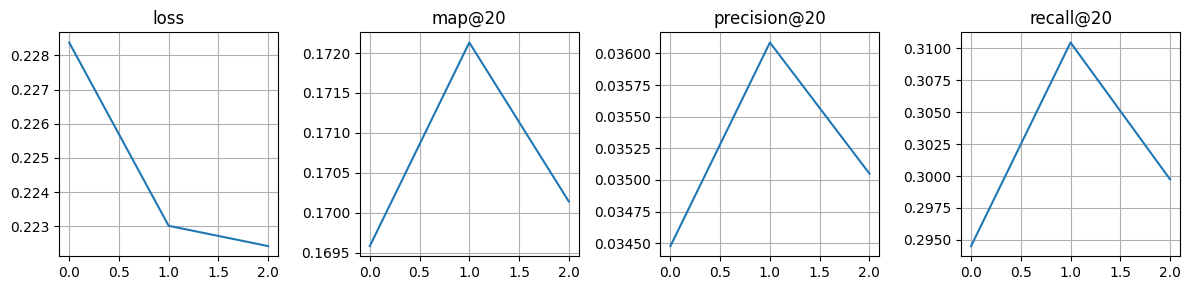

In [12]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i, metric_name in enumerate(df_metrics.columns):
    df_metrics[metric_name].plot(ax=axes[i], grid=True, title=metric_name)
fig.tight_layout()

### Save model

In [7]:
model_name = 'none'

save_folder_name = f'model_saves/{model_name}'
! mkdir "$save_folder_name"
torch.save(best_state_dict, f'./{save_folder_name}/gnn_state.pt')
torch.save(optimizer.state_dict(), f'./{save_folder_name}/adam_state.pt')
df_metrics.to_csv(f'./model_saves/dnn_metrics.csv')

## Example of making recommendations by Graph Neural Network

In [3]:
gnn_model = GNN(num_layers=1, hidden_channels=64,
                user_dim=user_dim, movie_dim=movie_dim,
                normalize=False, aggr_type='max-pool', dropout_p=None)

model_name = 'trl_50_map0.1845'
save_folder_name = f'model_saves/{model_name}'
gnn_model.load_state_dict(torch.load(f'./{save_folder_name}/gnn_state.pt'))
gnn_model.to(device);

In [5]:
df_inter = pd.read_csv('data/processed/interactions.csv')
df_items = pd.read_csv('data/processed/items.csv')
df_users = pd.read_csv('data/processed/users.csv')

users_mapping = {user_id: idx for idx, user_id in users_rev_mapping.items()}
movies_mapping = {movie_id: idx for idx, movie_id in movies_rev_mapping.items()}
movies_id_to_df_idx = {movie_id: df_idx for df_idx, movie_id in df_items['item_id'].items()}

In [23]:
user_id = 148609
df_inter[df_inter['user_id'] == user_id].merge(df_items)

,user_id,item_id,last_watch_dt,watched_pct,content_type,title,genres,age_rating,description,keywords,views
0,148609,12395,2021-03-23,100.0,film,"Беги, мальчик, беги","боевики, драмы, биография, военные",16,"Это судьба восьмилетнего мальчика, беглеца из ...","вторая мировая война, варшавское гетто, дети, ...",100
1,148609,11885,2021-04-01,100.0,film,Хан Соло: Звёздные войны. Истории,"боевики, фантастика, приключения",12,Фильм расскажет о похождениях юного космическо...,"космический корабль, приквел, спин-офф, контра...",523
2,148609,13713,2021-04-01,0.0,film,Звёздные войны: Скрытая угроза,"боевики, фантастика, приключения",0,Мирная и процветающая планета Набу. Торговая ф...,"пророчество, сенат, королева, надзиратель, гал...",362
3,148609,13980,2021-04-11,100.0,film,Изгой-один: Звёздные войны. Истории.,"боевики, фантастика, приключения",16,Сопротивление собирает отряд для выполнения ос...,"бунтарь, космический корабль, космическое сраж...",362


In [24]:
df_users[df_users['user_id'] == user_id]

,user_id,age,income,sex,kids_flg
80881,148609,age_45_54,income_20_40,М,0


In [25]:
users_idx = torch.tensor([users_mapping[user_id]])
with torch.no_grad():
    recs = gnn_model.recommend(users_idx, data,
        top_count=1000, k=20, model_device=device, faiss_device=faiss_device)
    
rec_ids = np.vectorize(movies_rev_mapping.get)(recs.squeeze())
rec_df_idx = np.vectorize(movies_id_to_df_idx.get)(rec_ids)
df_items.iloc[rec_df_idx].reset_index(drop=True)

,item_id,content_type,title,genres,age_rating,description,keywords,views
0,8980,film,Звёздные войны: Эпизод 4 — Новая надежда,"боевики, фантастика, фэнтези, приключения",6,Татуин. Планета-пустыня. Уже постаревший рыцар...,"андроид, галактика, отшельник, звезда смерти, ...",407
1,4774,film,Морской бой,"боевики, фантастика, триллеры, приключения",12,В 2006 году NASA передаёт сигналы на одну из в...,"борьба, военно-морской флот соединенных штатов...",716
2,8437,film,Капитан Марвел,"боевики, фантастика",16,После столкновения с враждующими инопланетными...,"супергерой, основанный на комиксе, супергероин...",1019
3,8821,film,Стражи Галактики. Часть 2,"боевики, фантастика, приключения, комедии",16,Все в сборе: землянин Питер Квилл (Звездный Ло...,"продолжение, супергерой, основанный на комиксе...",812
4,10680,film,Дэдпул 2,"боевики, фантастика, приключения, комедии",18,Единственный и неповторимый болтливый наемник ...,"герой, мутант, наемник, сиквел, супергерой, ос...",625
5,15297,series,Клиника счастья,"драмы, мелодрамы",18,"Успешный сексолог Алена уверена, что нашла фор...","Клиника счастья, Клиника, Счастье, Клиника сча...",30157
6,3587,film,Железный человек,"боевики, фантастика, приключения",12,Миллиардер-изобретатель Тони Старк попадает в ...,"Ближний Восток, торговец оружием, Малибу, супе...",767
7,3936,film,Звёздные войны: Скайуокер. Восход,"боевики, фантастика, приключения",16,Фильм завершает невероятную историю семьи Скай...,"космическая сага, Аварийная посадка, Актер уме...",465
8,1785,film,Чёрная пантера,"боевики, фантастика, приключения",16,"С первого взгляда можно решить, что Ваканда - ...","африка, супергерой, по мотивам комиксов, 1990-...",1530
9,12841,film,Стражи Галактики,"боевики, фантастика, приключения, комедии",12,Отважному путешественнику Питеру Квиллу попада...,"космический корабль, основанный на комиксе, ко...",1316


## Submission on ODS

In [6]:
submission_ids = pd.read_csv('./data/sample_submission.csv')['user_id']
submission_idx = np.vectorize(users_mapping.get)(submission_ids)

In [ ]:
# Cold users
cold_users_ids = submission_ids[np.flatnonzero(submission_idx == None)].values
pop_ids = np.vectorize(movies_rev_mapping.get)(np.arange(10))

submission_recs = pd.DataFrame(cold_users_ids, columns=['Id'])
submission_recs['Predicted'] = torch.tensor(pop_ids).repeat(
    len(cold_users_ids)).reshape(-1, 10).tolist()

In [9]:
# Warm users
warm_users_indices = submission_idx[np.flatnonzero(submission_idx != None)]
warm_users_ids = np.vectorize(users_rev_mapping.get)(warm_users_indices)
with torch.no_grad():
    recs = gnn_model.recommend(
        users_idx=torch.tensor(warm_users_indices.astype(int)), data=data,
        top_count=2000, k=10, batch_size=128,
        model_device=device, faiss_device=faiss_device)
recs_ids = np.vectorize(movies_rev_mapping.get)(recs.to(torch.int))

warm_submission_recs = pd.DataFrame(warm_users_ids, columns=['Id'])
warm_submission_recs['Predicted'] = recs_ids.tolist()

In [33]:
submission_recs = pd.concat([submission_recs, warm_submission_recs]).sort_values('Id')

In [34]:
submission_recs.head()

,Id,Predicted
0,3,"[10440, 15297, 9728, 13865, 4151, 3734, 4880, ..."
0,11,"[10440, 4151, 1559, 11245, 13865, 4880, 12396,..."
1,29,"[10440, 15297, 9728, 13865, 4151, 3734, 4880, ..."
2,30,"[10440, 15297, 9728, 13865, 4151, 3734, 4880, ..."
3,33,"[10440, 15297, 9728, 13865, 4151, 3734, 4880, ..."


In [35]:
submission_recs.to_csv('./data/submission.csv', index=False)